In [1]:
import os

print(os.getcwd())
#os.chdir('/mnt/cpp_projects/low-level-deep-learning/')
os.chdir('/home/thomas/cpp-projects/low-level-deep-learning')
print(os.getcwd())

/home/thomas/cpp-projects/low-level-deep-learning/examples
/home/thomas/cpp-projects/low-level-deep-learning


In [2]:
from sklearn.datasets import load_diabetes
import numpy as np

In [3]:
diabetes = load_diabetes()

In [4]:
data = diabetes.data.astype(np.float32)
targets = diabetes.target.astype(np.float32)
features = diabetes.feature_names

print(data.shape, targets.shape)

(442, 10) (442,)


In [5]:
# First add a dimension to targets
targets_ = targets.reshape(-1, 1)
print(targets_.shape)

(442, 1)


A note on examing the shapes of the backward pass as it is more complicated to understand

In [6]:
# examining the data transformations of the forward pass
W = np.random.randn(data.shape[1], 1)
print(data.shape, W.shape, type(data))
(data @ W).shape
N = data @ W
P = N + 3.2
print("N:", N.shape, "P:", P.shape)

# examining the data transformations of the gradients
dLdP = -2 * (targets_ - P)
dPdN = np.ones_like(N)
dPdB = np.ones((1, 1), dtype=np.float32)

dLdN = dLdP * dPdN

dNdW = data.transpose()
dLdW = dNdW @ dLdN

dLdB = (dLdP * dPdB)
print("pre aggregated dLdB", dLdB.shape, "post aggregated", dLdB.sum(axis=0).shape)
print("dLdP:", dLdP.shape, "dLdN:", dLdN.shape, "dLdW:", dLdW.shape)



(442, 10) (10, 1) <class 'numpy.ndarray'>
N: (442, 1) P: (442, 1)
pre aggregated dLdB (442, 1) post aggregated (1,)
dLdP: (442, 1) dLdN: (442, 1) dLdW: (10, 1)


In [7]:
import cppapi
import random

W = np.random.randn(data.shape[1], 1).astype(np.float32)
random_intercept = random.random()
linear = cppapi.LinearRegression(data.shape[0], data.shape[1], random_intercept, W, 1)
loss = linear._forward_lin_reg_one_step(data, targets_, cppapi.Loss.RMSE)

In [8]:
print("cpp api loss", loss)

cpp api loss 170.4063720703125


In [9]:
from python_tests.manual_linear_regression import forward_linear_regression, loss_gradients
from typing import Dict

weights: Dict[str, np.ndarray] = {}
weights['W'] = W
weights['B'] = np.array([[random_intercept]], dtype=np.float32)
pyloss, forward_info = forward_linear_regression(data, targets_, weights)

In [10]:
import matplotlib.pyplot as plt


print(forward_info.keys())

print("Python/C++ N output close?", np.allclose(forward_info['N'], linear.N))
print("Python/C++ N output close?", np.allclose(forward_info['P'], linear.P))
print(forward_info['P'].shape, linear.P.shape)
print(type(float(pyloss)), type(loss))
print("Loss discrepency Py/C++", pyloss, "/", loss)

dict_keys(['X', 'N', 'P', 'y'])
Python/C++ N output close? True
Python/C++ N output close? False
(442, 1) (442, 1)
<class 'float'> <class 'float'>
Loss discrepency Py/C++ 170.40633 / 170.4063720703125


In [11]:
# perform the python backward differentiation step
loss_gradients_output = loss_gradients(forward_info, weights)
# perform the C++ API backward differentiation step
linear._gradient_backward_step(data, targets_)

In [12]:
print("Weights (dLdW) Python==C++:", np.allclose(linear.dLdW, loss_gradients_output['W']))
print(loss_gradients_output['B'], linear.dLdB)

Weights (dLdW) Python==C++: True
[-134368.34] -134368.34375


API data preparation and learning 

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

s = StandardScaler()
data = s.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3, random_state=80718)

y_train, y_tess = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

linear.train(X_train, y_train, 1000, 100, cppapi.Loss.RMSE, 1e-3)

API prediction

In [26]:
yhat_train = linear.predict(X_train)
yhat_test = linear.predict(X_test)

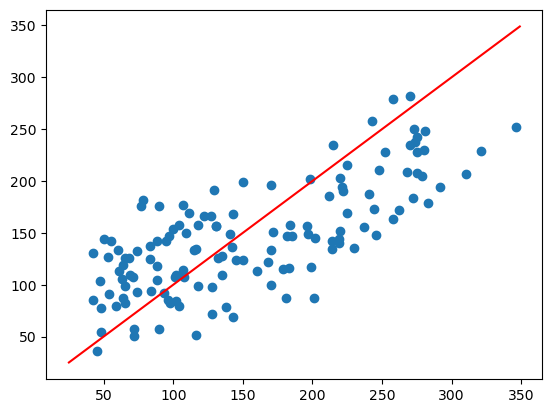

In [27]:
plt.scatter(y_test, yhat_test)
l = np.arange(25, 350, 1)
plt.plot(l, l, c='r')

Get the learned weight vector. 

In [25]:
print(linear.W)

[[  0.46697757]
 [-11.15831   ]
 [ 20.89755   ]
 [ 15.714529  ]
 [-39.379467  ]
 [ 24.295204  ]
 [  1.751861  ]
 [  3.5973706 ]
 [ 35.612797  ]
 [  4.6352243 ]]
